In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class CircuitOptimizerAgent(nn.Module):
    def __init__(self, num_qubits, num_gate_types, num_transform_rules, num_timesteps):
        super(CircuitOptimizerAgent, self).__init__()
        self.num_qubits = num_qubits
        self.num_gate_types = num_gate_types
        self.num_transform_rules = num_transform_rules
        self.num_timesteps = num_timesteps

        # 3D卷积层
        self.conv1 = nn.Conv3d(2, 16, kernel_size=3, padding=1)  # 输入通道2，输出通道16，核大小3x3x3，填充1
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool3d(2)  # 使用2x2x2的池化窗口

        # 计算池化后的维度
        pooled_dim = (num_timesteps // 2) * (num_qubits // 2) * (num_gate_types // 2)

        # 策略网络的全连接层
        self.fc1_policy = nn.Linear(16 * pooled_dim, 256)
        self.fc2_policy = nn.Linear(256, num_qubits * num_transform_rules * num_timesteps)

        # 价值网络的全连接层
        self.fc1_value = nn.Linear(16 * pooled_dim, 256)
        self.fc2_value = nn.Linear(256, 1)

    def forward(self, x):
        # 共享的卷积层
        x = self.pool(self.relu(self.conv1(x)))

        # 为全连接层展平数据
        x_flat = x.view(x.size(0), -1)

        # 策略网络
        policy = F.relu(self.fc1_policy(x_flat))
        policy = self.fc2_policy(policy)
        policy = policy.view(-1, self.num_qubits, self.num_transform_rules, self.num_timesteps)
        policy = F.softmax(policy, dim=-1)

        # 价值网络
        value = F.relu(self.fc1_value(x_flat))
        value = self.fc2_value(value)

        return policy, value


In [3]:
# 实例化模型
num_qubits = 5
num_gate_types = 3
num_transform_rules = 6
num_timesteps = 15
activation_probability = 0.1  # 设定任一门在任一位置激活的概率
agent = CircuitOptimizerAgent(num_qubits, num_gate_types, num_transform_rules, num_timesteps)


In [4]:
# 初始化四维数组，最后一维表示是否激活
quantum_circuit_data = np.zeros((num_qubits, num_gate_types, num_timesteps, 2))

# 随机选择一些位置设置为1，模拟量子门的激活
np.random.seed(42)  # 设置随机种子以确保可复现性
for qubit in range(num_qubits):
    for gate_type in range(num_gate_types):
        for time in range(num_timesteps):
            if np.random.random() < activation_probability:
                quantum_circuit_data[qubit, gate_type, time, 1] = 1  # 设置为1表示激活

# 最后的一维是0和1，这里我们用第一个维度设置其它为0表示无激活
quantum_circuit_data[:, :, :, 0] = 1 - quantum_circuit_data[:, :, :, 1]

# 添加batch和channel维度
data_tensor = torch.tensor(quantum_circuit_data, dtype=torch.float).unsqueeze(0).permute(0, 4, 3, 1, 2)
# 这里用 permute 将数据调整为 (batch_size, channels, depth, height, width)
# 对应的shape是 (1, 2, num_timesteps, num_gate_types, num_qubits)

In [5]:
# 运行模型
policy_output, value_output = agent(data_tensor)
print("Policy Output shape:", policy_output.shape)
print("Policy Output:", policy_output)
print("Value Output shape:", value_output.shape)
print("Value Output:", value_output)

Policy Output shape: torch.Size([1, 5, 6, 15])
Policy Output: tensor([[[[0.0689, 0.0680, 0.0663, 0.0645, 0.0700, 0.0722, 0.0643, 0.0619,
           0.0553, 0.0579, 0.0648, 0.0807, 0.0668, 0.0687, 0.0698],
          [0.0673, 0.0649, 0.0577, 0.0660, 0.0724, 0.0640, 0.0573, 0.0685,
           0.0725, 0.0758, 0.0631, 0.0612, 0.0776, 0.0615, 0.0704],
          [0.0632, 0.0703, 0.0824, 0.0754, 0.0578, 0.0680, 0.0557, 0.0617,
           0.0641, 0.0717, 0.0649, 0.0719, 0.0683, 0.0633, 0.0614],
          [0.0673, 0.0671, 0.0652, 0.0623, 0.0720, 0.0671, 0.0727, 0.0742,
           0.0640, 0.0567, 0.0660, 0.0689, 0.0701, 0.0658, 0.0607],
          [0.0609, 0.0641, 0.0568, 0.0728, 0.0739, 0.0574, 0.0651, 0.0675,
           0.0639, 0.0619, 0.0647, 0.0680, 0.0664, 0.0752, 0.0814],
          [0.0650, 0.0590, 0.0812, 0.0695, 0.0524, 0.0678, 0.0655, 0.0696,
           0.0704, 0.0710, 0.0602, 0.0617, 0.0763, 0.0753, 0.0552]],

         [[0.0646, 0.0711, 0.0677, 0.0623, 0.0712, 0.0685, 0.0580, 0.0708,
   

: 

In [6]:
import numpy as np
import torch

# 设置量子电路数据的参数
num_qubits = 5
num_gate_types = 3
num_timesteps = 10
activation_probability = 0.1  # 设定任一门在任一位置激活的概率

# 初始化四维数组，最后一维表示是否激活
quantum_circuit_data = np.zeros((num_qubits, num_gate_types, num_timesteps, 2))

# 随机选择一些位置设置为1，模拟量子门的激活
np.random.seed(42)  # 设置随机种子以确保可复现性
for qubit in range(num_qubits):
    for gate_type in range(num_gate_types):
        for time in range(num_timesteps):
            if np.random.random() < activation_probability:
                quantum_circuit_data[qubit, gate_type, time, 1] = 1  # 设置为1表示激活

# 最后的一维是0和1，这里我们用第一个维度设置其它为0表示无激活
quantum_circuit_data[:, :, :, 0] = 1 - quantum_circuit_data[:, :, :, 1]

# 添加batch和channel维度
data_tensor = torch.tensor(quantum_circuit_data, dtype=torch.float).unsqueeze(0).permute(0, 4, 3, 1, 2)
# 这里用 permute 将数据调整为 (batch_size, channels, depth, height, width)
# 对应的shape是 (1, 2, num_timesteps, num_gate_types, num_qubits)


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class PolicyNetwork3D(nn.Module):
    def __init__(self, num_qubits, num_gate_types, num_transform_rules, num_timesteps):
        super(PolicyNetwork3D, self).__init__()
        self.num_qubits = num_qubits
        self.num_gate_types = num_gate_types
        self.num_transform_rules = num_transform_rules
        self.num_timesteps = num_timesteps

        # 3D卷积层
        self.conv1 = nn.Conv3d(2, 16, kernel_size=3, padding=1)  # 输入通道2，输出通道16，核大小3x3x3，填充1
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool3d(2)  # 池化窗口2x2x2

        # 计算池化后的维度
        pooled_dim = (num_timesteps // 2) * (num_qubits // 2) * (num_gate_types // 2)
        self.fc1 = nn.Linear(16 * pooled_dim, 256)
        self.fc2 = nn.Linear(256, num_qubits * num_gate_types * num_transform_rules)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)  # 展平操作，为全连接层准备
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, self.num_qubits, self.num_gate_types, self.num_transform_rules)
        return F.softmax(x, dim=-1)


In [8]:
num_qubits = 5
num_gate_types = 3
num_transform_rules = 10
num_timesteps = 10

# 实例化策略网络
policy_net = PolicyNetwork3D(num_qubits, num_gate_types, num_transform_rules, num_timesteps)

# 运行模型
output = policy_net(data_tensor)
print("Output shape:", output.shape)
print("Policy Output:", output)


Output shape: torch.Size([1, 5, 3, 10])
Policy Output: tensor([[[[0.1039, 0.0996, 0.1015, 0.1149, 0.0973, 0.1027, 0.0922, 0.0999,
           0.0970, 0.0909],
          [0.0960, 0.0880, 0.1102, 0.0994, 0.1076, 0.0843, 0.0957, 0.1180,
           0.0978, 0.1029],
          [0.1164, 0.1072, 0.0915, 0.0997, 0.1067, 0.0917, 0.0944, 0.1035,
           0.1020, 0.0869]],

         [[0.0892, 0.0999, 0.1040, 0.1069, 0.1001, 0.0884, 0.0951, 0.1065,
           0.1062, 0.1036],
          [0.1023, 0.0918, 0.1104, 0.1068, 0.0866, 0.1189, 0.0995, 0.0929,
           0.0973, 0.0935],
          [0.1064, 0.1147, 0.1114, 0.1080, 0.0966, 0.1049, 0.0880, 0.0808,
           0.0903, 0.0989]],

         [[0.1012, 0.1092, 0.0961, 0.0950, 0.0989, 0.0998, 0.1028, 0.1072,
           0.0940, 0.0958],
          [0.1124, 0.0977, 0.0879, 0.1049, 0.0974, 0.0934, 0.1013, 0.1004,
           0.1056, 0.0991],
          [0.0993, 0.1086, 0.0947, 0.0943, 0.0872, 0.0963, 0.1019, 0.1114,
           0.1011, 0.1052]],

         [[0

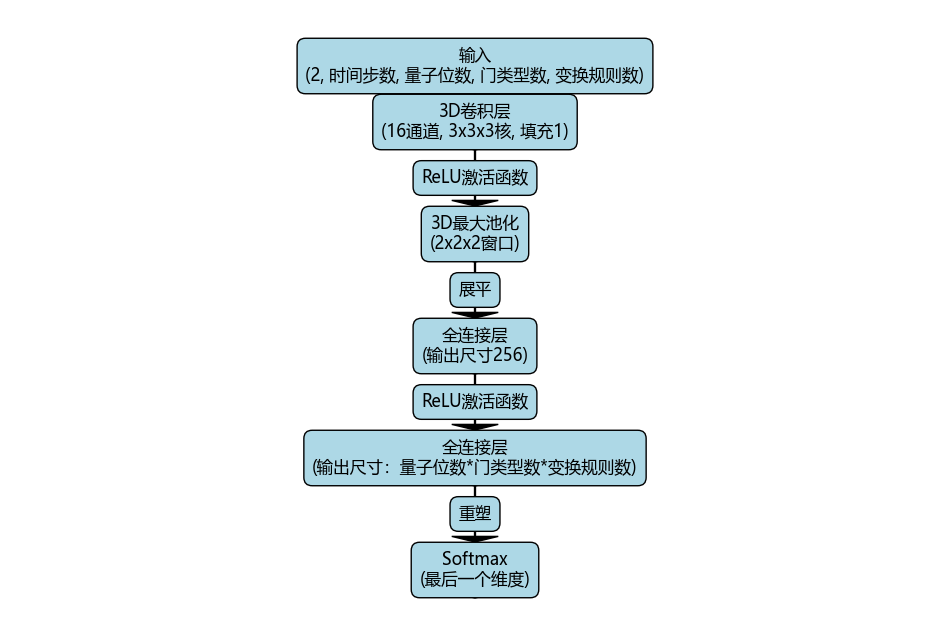

In [1]:
import matplotlib.pyplot as plt

def draw_policy_network():
    # 在这里设置系统已有的中文字体，如 'Microsoft YaHei'
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 替换为你系统中可用的中文字体
    plt.rcParams['axes.unicode_minus'] = False   # 正确显示负号

    fig, ax = plt.subplots(figsize=(12, 8))

    # 节点定义
    layers = [
        "输入\n(2, 时间步数, 量子位数, 门类型数, 变换规则数)",
        "3D卷积层\n(16通道, 3x3x3核, 填充1)",
        "ReLU激活函数",
        "3D最大池化\n(2x2x2窗口)",
        "展平",
        "全连接层\n(输出尺寸256)",
        "ReLU激活函数",
        "全连接层\n(输出尺寸：量子位数*门类型数*变换规则数)",
        "重塑",
        "Softmax\n(最后一个维度)"
    ]
    layer_positions = [(0.5, 10 - i) for i in range(len(layers))]

    # 绘制节点
    for pos, layer in zip(layer_positions, layers):
        ax.text(pos[0], pos[1], layer, fontsize=12, ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', edgecolor='black'))

    # 绘制箭头
    for i in range(len(layer_positions) - 1):
        ax.arrow(layer_positions[i][0], layer_positions[i][1] - 0.5, 0, -0.9, head_width=0.05, head_length=0.1, fc='k', ec='k')

    # 设置图表界限和样式
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 11)
    ax.axis('off')

    return fig

# 生成图表
fig = draw_policy_network()
plt.show()


确保`num_qubits`, `num_gate_types`, `num_transform_rules`等参数与之前的数据结构一一对应非常重要。以下是一个更详细的代码说明，它们是如何在整个过程中保持一致的：

### 数据生成与准备

首先，我们要确保生成的量子电路数据与模型所期望的输入格式相匹配。这个过程涉及初始化一个四维数组来表示量子比特、量子门类型、时间步数，以及激活状态。

```python
import numpy as np
import torch

# 设置量子电路数据的参数
num_qubits = 5
num_gate_types = 3
num_timesteps = 10
activation_probability = 0.1  # 设定任一门在任一位置激活的概率

# 初始化四维数组，最后一维表示是否激活
quantum_circuit_data = np.zeros((num_qubits, num_gate_types, num_timesteps, 2))

# 随机选择一些位置设置为1，模拟量子门的激活
np.random.seed(42)  # 设置随机种子以确保可复现性
for qubit in range(num_qubits):
    for gate_type in range(num_gate_types):
        for time in range(num_timesteps):
            if np.random.random() < activation_probability:
                quantum_circuit_data[qubit, gate_type, time, 1] = 1  # 设置为1表示激活

# 最后的一维是0和1，这里我们用第一个维度设置其它为0表示无激活
quantum_circuit_data[:, :, :, 0] = 1 - quantum_circuit_data[:, :, :, 1]

# 添加batch和channel维度
data_tensor = torch.tensor(quantum_circuit_data, dtype=torch.float).unsqueeze(0).permute(0, 4, 3, 1, 2)
# 这里用 permute 将数据调整为 (batch_size, channels, depth, height, width)
# 对应的shape是 (1, 2, num_timesteps, num_gate_types, num_qubits)
```

### 定义3D策略网络

策略网络的设计要匹配数据的维度和结构，确保输入数据能够正确处理并输出正确形状的概率分布。

```python
import torch.nn as nn
import torch.nn.functional as F

class PolicyNetwork3D(nn.Module):
    def __init__(self, num_qubits, num_gate_types, num_transform_rules, num_timesteps):
        super(PolicyNetwork3D, self).__init__()
        self.num_qubits = num_qubits
        self.num_gate_types = num_gate_types
        self.num_transform_rules = num_transform_rules
        self.num_timesteps = num_timesteps

        # 3D卷积层
        self.conv1 = nn.Conv3d(2, 16, kernel_size=3, padding=1)  # 输入通道2，输出通道16，核大小3x3x3，填充1
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool3d(2)  # 池化窗口2x2x2

        # 计算池化后的维度
        pooled_dim = (num_timesteps // 2) * (num_qubits // 2) * (num_gate_types // 2)
        self.fc1 = nn.Linear(16 * pooled_dim, 256)
        self.fc2 = nn.Linear(256, num_qubits * num_gate_types * num_transform_rules)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)  # 展平操作，为全连接层准备
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, self.num_qubits, self.num_gate_types, self.num_transform_rules)
        return F.softmax(x, dim=-1)
```

### 实例化模型并测试

确保在实例化模型和准备输入数据时，所有的参数都一致。

```python
num_qubits = 5
num_gate_types = 3
num_transform_rules = 10
num_timesteps = 10

# 实例化策略网络
policy_net = PolicyNetwork3D(num_qubits, num_gate_types, num_transform_rules, num_timesteps)

# 运行模型
output = policy_net(data_tensor)
print("Output shape:", output.shape)
print("Policy Output:", output)
```

### 解释和验证

1. **数据生成**：
   - 我们生成了一个四维数组`quantum_circuit_data`，其形状为 `(num_qubits, num_gate_types, num_timesteps, 2)`。
   - 最后一维表示是否激活的状态。
   - 通过`unsqueeze(0)`添加批次维度，通过`permute`将数据调整为 `(batch_size, channels, depth, height, width)`。

2. **模型设计**：
   - 卷积层`conv1`处理输入数据，将其转换为16个通道的特征图。
   - 池化层`pool`降低维度，提高计算效率。
   - 全连接层`fc1`和`fc2`用于将卷积后的特征映射到策略空间（变换规则的概率分布）。

3. **一致性保证**：
   - 在数据生成、模型实例化和前向传播过程中，所有参数（如`num_qubits`, `num_gate_types`, `num_transform_rules`, `num_timesteps`）保持一致，确保数据和模型的维度匹配。

通过这种方式，可以确保模型正确处理和理解量子电路数据，并输出相应的操作策略。

这个输出是策略网络（Policy Network）生成的概率分布张量，它表示在每个量子比特、量子门类别和变换规则下采取不同操作的概率。让我们逐层解释这个张量的结构和含义。

### 张量的结构和含义

1. **总体结构**:
   - 输出的张量形状是 `[1, num_qubits, num_gate_types, num_transform_rules]`，表示一个批次中的所有数据的概率分布。
   - 在具体的示例中，`num_qubits = 5`，`num_gate_types = 3`，`num_transform_rules = 10`。

2. **具体解释**:
   - `1`: 表示批次大小，这里是1，表示我们处理一个样本。
   - `num_qubits = 5`: 表示量子比特的数量。在这个张量中有5个切片，每个切片对应一个量子比特。
   - `num_gate_types = 3`: 表示量子门的类别数量。每个量子比特下有3个切片，每个切片对应一个量子门类别。
   - `num_transform_rules = 10`: 表示变换规则的数量。在每个量子比特和量子门类别的组合下，有10个值，每个值对应一个变换规则的概率。

### 示例输出的具体解释

考虑输出中的一个示例切片：

```plaintext
Policy Output: tensor([[[[0.0965, 0.1002, 0.0988, 0.0847, 0.0906, 0.1257, 0.1106, 0.0992, 0.1051, 0.0887],
                        [0.0986, 0.0923, 0.1119, 0.1133, 0.0832, 0.0842, 0.0942, 0.0983, 0.1087, 0.1153],
                        [0.0798, 0.0791, 0.1135, 0.0975, 0.1294, 0.1040, 0.0893, 0.0996, 0.1098, 0.0982]],

                       [[0.0839, 0.1187, 0.0987, 0.1165, 0.0948, 0.0904, 0.1067, 0.0972, 0.1063, 0.0868],
                        [0.0818, 0.1040, 0.1112, 0.1035, 0.0896, 0.1042, 0.0954, 0.0980, 0.1057, 0.1067],
                        [0.1023, 0.0915, 0.0888, 0.1134, 0.0938, 0.0885, 0.1039, 0.1103, 0.1111, 0.0964]],

                       [[0.1034, 0.1086, 0.1183, 0.1005, 0.0836, 0.0905, 0.1020, 0.1053, 0.0872, 0.1006],
                        [0.0979, 0.0913, 0.0994, 0.0972, 0.1147, 0.0958, 0.0982, 0.0906, 0.1103, 0.1048],
                        [0.1128, 0.1277, 0.0836, 0.0935, 0.0945, 0.0795, 0.1063, 0.1188, 0.0915, 0.0917]],

                       [[0.0913, 0.0823, 0.1259, 0.0890, 0.1043, 0.1024, 0.0927, 0.0919, 0.1236, 0.0967],
                        [0.0948, 0.0824, 0.0859, 0.1015, 0.1018, 0.1090, 0.1163, 0.0892, 0.1112, 0.1080],
                        [0.0937, 0.1006, 0.1057, 0.0827, 0.0986, 0.0820, 0.1243, 0.1106, 0.0887, 0.1131]],

                       [[0.1105, 0.1060, 0.1019, 0.0884, 0.0974, 0.0952, 0.0807, 0.1060, 0.0965, 0.1175],
                        [0.1066, 0.0930, 0.1014, 0.1038, 0.0882, 0.0963, 0.1090, 0.0915, 0.1092, 0.1011],
                        [0.0982, 0.0976, 0.1100, 0.1118, 0.1060, 0.0906, 0.1051, 0.0969, 0.0904, 0.0933]]]])
```

- **最外层列表**：表示一个批次的数据（批次大小为1）。
- **第二层列表**：表示每个量子比特的数据（这里有5个量子比特）。
- **第三层列表**：表示每个量子比特上的量子门类别的数据（这里每个量子比特有3种量子门类别）。
- **第四层列表**：表示每个量子门类别下的变换规则的概率分布（这里每个量子门类别有10种变换规则）。

### 例子详解

```plaintext
[[[0.0965, 0.1002, 0.0988, 0.0847, 0.0906, 0.1257, 0.1106, 0.0992, 0.1051, 0.0887],
  [0.0986, 0.0923, 0.1119, 0.1133, 0.0832, 0.0842, 0.0942, 0.0983, 0.1087, 0.1153],
  [0.0798, 0.0791, 0.1135, 0.0975, 0.1294, 0.1040, 0.0893, 0.0996, 0.1098, 0.0982]],

 [[0.0839, 0.1187, 0.0987, 0.1165, 0.0948, 0.0904, 0.1067, 0.0972, 0.1063, 0.0868],
  [0.0818, 0.1040, 0.1112, 0.1035, 0.0896, 0.1042, 0.0954, 0.0980, 0.1057, 0.1067],
  [0.1023, 0.0915, 0.0888, 0.1134, 0.0938, 0.0885, 0.1039, 0.1103, 0.1111, 0.0964]],

 [[0.1034, 0.1086, 0.1183, 0.1005, 0.0836, 0.0905, 0.1020, 0.1053, 0.0872, 0.1006],
  [0.0979, 0.0913, 0.0994, 0.0972, 0.1147, 0.0958, 0.0982, 0.0906, 0.1103, 0.1048],
  [0.1128, 0.1277, 0.0836, 0.0935, 0.0945, 0.0795, 0.1063, 0.1188, 0.0915, 0.0917]],

 [[0.0913, 0.0823, 0.1259, 0.0890, 0.1043, 0.1024, 0.0927, 0.0919, 0.1236, 0.0967],
  [0.0948, 0.0824, 0.0859, 0.1015, 0.1018, 0.1090, 0.1163, 0.0892, 0.1112, 0.1080

],
  [0.0937, 0.1006, 0.1057, 0.0827, 0.0986, 0.0820, 0.1243, 0.1106, 0.0887, 0.1131]],

 [[0.1105, 0.1060, 0.1019, 0.0884, 0.0974, 0.0952, 0.0807, 0.1060, 0.0965, 0.1175],
  [0.1066, 0.0930, 0.1014, 0.1038, 0.0882, 0.0963, 0.1090, 0.0915, 0.1092, 0.1011],
  [0.0982, 0.0976, 0.1100, 0.1118, 0.1060, 0.0906, 0.1051, 0.0969, 0.0904, 0.0933]]]]
```

在这个示例中，每个数字表示在该量子比特、该量子门类别和该变换规则下的概率。例如，`0.0965` 表示在量子比特0，量子门类别0时，选择变换规则0的概率为9.65%。

希望这些解释可以帮助您理解这个张量的结构和意义。如果有进一步的问题，请随时告诉我！

import torch
import torch.nn as nn
import torch.nn.functional as F

class PolicyNetwork3D(nn.Module):
    def __init__(self, num_qubits, num_gate_types, num_transform_rules, num_timesteps):
        super(PolicyNetwork3D, self).__init__()
        # 输入的channel数为2，因为数据最后一维有两个通道（激活与未激活）
        self.conv1 = nn.Conv3d(2, 16, kernel_size=(3, 3, 3), padding=1)  # 使用3x3x3的核和padding=1
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool3d(2)  # 使用2x2x2的池化窗口
        # 计算池化后的维度
        pool_size = (num_timesteps // 2) * (num_qubits // 2) * (num_gate_types // 2)
        self.fc1 = nn.Linear(16 * pool_size, 256)
        self.fc2 = nn.Linear(256, num_qubits * num_gate_types * num_transform_rules)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)  # 展平操作，为全连接层准备
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, num_qubits, num_gate_types, num_transform_rules)
        return F.softmax(x, dim=-1)

# 实例化模型
num_qubits = 5
num_gate_types = 3
num_transform_rules = 10
num_timesteps = 10
policy_net = PolicyNetwork3D(num_qubits, num_gate_types, num_transform_rules, num_timesteps)


import numpy as np
data = np.random.rand(1, 2, num_qubits, num_gate_types, num_timesteps)  # 模拟一个batch的数据
data_tensor = torch.tensor(data, dtype=torch.float)


In [9]:
# 运行模型
output = policy_net(data_tensor)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 5, 3, 10])


import torch
import torch.nn as nn
import torch.nn.functional as F

num_qubits = 5
num_gate_types = 3
num_timesteps = 10
num_transform_rules = 10
batch_size = 32  # 示例批次大小

class PolicyNetwork3D(nn.Module):
    def __init__(self, num_qubits, num_gate_types, num_transform_rules, num_timesteps, batch_size):
        super(PolicyNetwork3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool3d(2)
        # 计算池化后的尺寸，这是必须的以确保全连接层的输入尺寸正确
        pool_size = num_timesteps // 2 * num_qubits // 2 * num_gate_types // 2
        self.fc1 = nn.Linear(16 * pool_size, 256)
        self.fc2 = nn.Linear(256, num_qubits * num_gate_types * num_transform_rules)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(-1, 16 * (num_timesteps // 2) * (num_qubits // 2) * (num_gate_types // 2))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, num_qubits, num_gate_types, num_transform_rules)
        return F.softmax(x, dim=-1)


policy_net = PolicyNetwork3D(num_qubits, num_gate_types, num_transform_rules, num_timesteps, batch_size)
